In [1]:
import numpy as np

import get
import matplotlib.pyplot as plt
import dask
import dask.dataframe as dd
from dask.distributed import Client, progress
from sklearn.preprocessing import MinMaxScaler
client = Client(n_workers=2, threads_per_worker=2, memory_limit='2GB')
client

Client Scheduler: tcp://127.0.0.1:53355 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 4.00 GB


In [62]:
SPY = get.daily('SPY', outputsize = 'full')
SPY = dd.from_pandas(SPY, npartitions = len(SPY.columns))

In [ ]:
%matplotlib qt
plt.figure()
plt.scatter(SPY.timestamp.compute(), SPY.adjusted_close.compute())
#plt.plot(TBBK['volume'])
#plt.plot(SPY["high"])
#plt.plot(SPY["low"])
#plt.plot(SPY["close"])
plt.title('SPY history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
#plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

Computer keeps crashing, but using a little research I found that the first crash is 2008.
Lets look at this a bit closer

In [63]:
SPY = SPY[SPY.timestamp >= '2008-10-01']
SPY =  SPY[SPY.timestamp <= '2009-05-31']
SPY = SPY.set_index(SPY.timestamp)

Text(0.5, 0, 'Days')

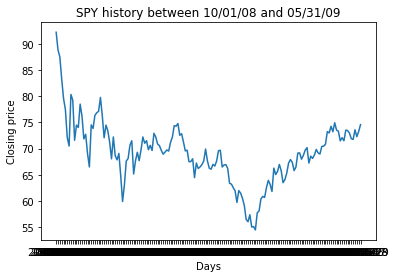

In [65]:
%matplotlib inline
plt.figure()
plt.plot(SPY.adjusted_close.compute())
plt.title('SPY history between 10/01/08 and 05/31/09')
plt.ylabel('Closing price')
plt.xlabel('Days')

That offers a pretty good look at what happened durring this period, enough to train a predictor.

In [66]:
SPY.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'adjusted_close', 'volume',
       'dividend_amount', 'split_coefficient'],
      dtype='object')

In [67]:
#Select the data we wanrt
pre_selected_spy = SPY[['open', 'high','low',  'volume', 'adjusted_close']]
selected_spy = pre_selected_spy.to_dask_array()
sc = MinMaxScaler(feature_range=(0, 1))
scaled_SPY = sc.fit_transform(selected_spy.compute())

In [77]:
#timestep of 5 days
x_train = list() 
y_train = list()
for i in range(5, scaled_SPY.shape[0]-1):
    x_train.append(scaled_SPY[i-5:i, 0:4])
    y_train.append(scaled_SPY[i+1, 4])
x_t = np.array(x_train)
y_t = np.array(y_train)

Time to create predictor. This architectre has taken quite a bit of fiddling, but finally has worked. The h5 should be in this repo if you would like to use the network yourself

In [70]:

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.losses import MeanSquaredError

In [87]:
model = Sequential(layers = [
    LSTM(50, input_shape = (5, 4)), Dropout(0.2),
    Dense(50, activation = 'sigmoid', use_bias = False),
    Dropout(0.3),
    Dense(1, activation = 'sigmoid')
])

In [88]:
model.compile(optimizer = 'Adam',loss = MeanSquaredError())

In [89]:
model.build()

In [ ]:
model.fit(x_t, y_t, verbose = 2, epochs = 200)

One crash is not enough, we need to find 2018 as well, which lasted from 9/17/2018 till 4/15/2019

In [91]:
SPY = get.daily('SPY', outputsize = 'full')

SPY = dd.from_pandas(SPY, npartitions = len(SPY.columns))

In [93]:
SPY = SPY[SPY.timestamp >= '2018-09-17']
SPY = SPY[SPY.timestamp <= '2019-04-15']

In [94]:
SPY = SPY.set_index('timestamp')

In [95]:
#Select the data we wanrt
pre_selected_spy = SPY[['open', 'high','low',  'adjusted_close','volume']]
selected_spy = pre_selected_spy.to_dask_array()
sc = MinMaxScaler(feature_range=(0, 1))
scaled_SPY = sc.fit_transform(selected_spy.compute())

In [96]:
#timestep of 5 days
x_train = list() 
y_train = list()
for i in range(5, scaled_SPY.shape[0]-1):
    x_train.append(scaled_SPY[i-5:i, 0:4])
    y_train.append(scaled_SPY[i+1, 4])
x_t = np.array(x_train)
y_t = np.array(y_train)

In [98]:
model.fit(x_t, y_t, epochs = 300)

Train on 139 samples
Epoch 1/300
139/139 [==============================] - 0s 251us/sample - loss: 0.0517
Epoch 2/300
139/139 [==============================] - 0s 222us/sample - loss: 0.0483
Epoch 3/300
139/139 [==============================] - 0s 230us/sample - loss: 0.0424
Epoch 4/300
139/139 [==============================] - 0s 208us/sample - loss: 0.0416
Epoch 5/300
139/139 [==============================] - 0s 201us/sample - loss: 0.0428
Epoch 6/300
139/139 [==============================] - 0s 179us/sample - loss: 0.0401
Epoch 7/300
139/139 [==============================] - 0s 187us/sample - loss: 0.0394
Epoch 8/300
139/139 [==============================] - 0s 186us/sample - loss: 0.0394
Epoch 9/300
139/139 [==============================] - 0s 179us/sample - loss: 0.0373
Epoch 10/300
139/139 [==============================] - 0s 179us/sample - loss: 0.0385
Epoch 11/300
139/139 [==============================] - 0s 179us/sample - loss: 0.0396
Epoch 12/300
139/139 [=========

Now I will use this crash as test data

In [166]:
SPY = get.daily('SPY', outputsize = 'full')
SPY = dd.from_pandas(SPY, npartitions = len(SPY.columns))

In [167]:
SPY = SPY[SPY.timestamp >= '2020-02-10']

In [168]:
SPY = SPY.set_index('timestamp')

In [169]:
pre_selected_spy = SPY[['open', 'high','low',  'volume', 'adjusted_close']]
selected_spy = pre_selected_spy.to_dask_array()
sc = MinMaxScaler(feature_range=(0, 1))
scaled_SPY = sc.fit_transform(selected_spy.compute())

In [170]:
SPY.compute()

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
timestamp,,,,,,,,
2020-02-10,331.2300,334.7500,331.1900,334.68,334.68,41779456,0.0,1.0
2020-02-11,336.1697,337.0200,334.6840,335.26,335.26,54773045,0.0,1.0
2020-02-12,336.8300,337.6500,336.4300,337.42,337.42,42844434,0.0,1.0
2020-02-13,335.8621,338.1200,335.5600,337.06,337.06,54038002,0.0,1.0
2020-02-14,337.5100,337.7300,336.2000,337.60,337.60,64518123,0.0,1.0
2020-02-18,336.5100,337.6677,335.2100,336.73,336.73,57195407,0.0,1.0
2020-02-19,337.7900,339.0800,337.4800,338.34,338.34,48587393,0.0,1.0
2020-02-20,337.7423,338.6400,333.6817,336.95,336.95,73891268,0.0,1.0
2020-02-21,335.4700,335.8100,332.5800,333.48,333.48,113656552,0.0,1.0


In [171]:
scaled_SPY

array([[0.93539492, 0.95278081, 0.94253609, 0.        , 0.96283887],
       [0.98404274, 0.97753544, 0.97445642, 0.03735587, 0.96872779],
       [0.9905456 , 0.98440567, 0.99040745, 0.00306175, 0.99065895],
       [0.98101339, 0.98953108, 0.98245935, 0.03524266, 0.98700376],
       [0.99724247, 0.98527808, 0.98830623, 0.06537244, 0.99248655],
       [0.98739413, 0.98459869, 0.97926183, 0.04432003, 0.98365316],
       [1.        , 1.        , 1.        , 0.01957245, 1.        ],
       [0.99953023, 0.99520174, 0.96529965, 0.09231973, 0.98588689],
       [0.97715186, 0.96434024, 0.95523479, 0.20664277, 0.95065489],
       [0.85572188, 0.93982879, 0.8516353 , 0.34272744, 0.83835922],
       [0.86360055, 0.84220284, 0.76438882, 0.50537304, 0.73916134],
       [0.7674808 , 0.77131952, 0.75534442, 0.43422767, 0.72748502],
       [0.68160331, 0.6999313 , 0.63484378, 0.69218649, 0.58544015],
       [0.5165452 , 0.55083969, 0.52548876, 0.98648713, 0.5727485 ],
       [0.61020288, 0.67371865, 0.

In [173]:
#timestep of 5 days
x_train = list() 
y_train = list()
for i in range(5, scaled_SPY.shape[0]-1):
    x_train.append(scaled_SPY[i-5:i, 0:4])
    y_train.append(scaled_SPY[i+1, 4])
x_t = np.array(x_train)
y_t = np.array(y_train)

In [174]:
model.fit(x_t, y_t, epochs = 300)

Train on 22 samples
Epoch 1/300
22/22 [==============================] - 0s 587us/sample - loss: 0.0144
Epoch 2/300
22/22 [==============================] - 0s 226us/sample - loss: 0.0178
Epoch 3/300
22/22 [==============================] - 0s 272us/sample - loss: 0.0136
Epoch 4/300
22/22 [==============================] - 0s 227us/sample - loss: 0.0183
Epoch 5/300
22/22 [==============================] - 0s 227us/sample - loss: 0.0139
Epoch 6/300
22/22 [==============================] - 0s 181us/sample - loss: 0.0154
Epoch 7/300
22/22 [==============================] - 0s 181us/sample - loss: 0.0120
Epoch 8/300
22/22 [==============================] - 0s 227us/sample - loss: 0.0140
Epoch 9/300
22/22 [==============================] - 0s 225us/sample - loss: 0.0123
Epoch 10/300
22/22 [==============================] - 0s 272us/sample - loss: 0.0093
Epoch 11/300
22/22 [==============================] - 0s 227us/sample - loss: 0.0101
Epoch 12/300
22/22 [==============================] - 

So what should the price be today?

In [ ]:
So what should the data be today

In [176]:
model.predict(np.asarray([x_t[-1]]))

array([[0.03238191]], dtype=float32)

In [179]:
max_ = sc.data_max_
min_ = sc.data_min_

In [185]:
0.032*(max_[4]-min_[4] ) + min_[4]

243.00168